In [1]:
import rootutils
from pathlib import Path

rootutils.setup_root(Path.cwd(), indicator=".project-root", pythonpath=True)

import numpy as np
import torch

from src.viaABC.systems import SpatialSIR3D
from src.models.lightning_module import PreTrainLightningSpatial
from src.models.components.models import MaskedAutoencoderViT3D

from src.utils.inference_utils import load_pretrained_model, labels2map

/home/jp4474/viaABC/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
observational_data = np.load("/home/jp4474/viaABC/data_temp/SPATIAL/data.npy")

In [3]:
observational_data.shape

(15, 80, 80)

In [4]:
model = load_pretrained_model(
    model_class=MaskedAutoencoderViT3D,
    lightning_class=PreTrainLightningSpatial,
    checkpoint_substr="SpatialSIR",
    folder_name='/home/jp4474/viaABC/tutorial_sirs',) 

img_size (80, 80) patch_size (8, 8) frames 15 t_patch_size 3
model initialized
Successfully loaded model


In [8]:
obs_input = torch.tensor(np.expand_dims(labels2map(observational_data), axis=0).transpose(0, 2, 1, 3, 4), dtype=torch.float32).to(model.device)

In [9]:
with torch.no_grad():
    _, _, pred = model(obs_input, mask_ratio=0.0)

In [10]:
abc = SpatialSIR3D(observational_data=observational_data, model=model, pooling_method='no_cls')

INFO:src.viaABC.viaABC:Initializing viaABC class
INFO:src.viaABC.viaABC:Model updated
INFO:src.viaABC.viaABC:viaABC class initialized with the following parameters:
INFO:src.viaABC.viaABC:num_parameters: 2
INFO:src.viaABC.viaABC:Mu: [0.2 0.2]
INFO:src.viaABC.viaABC:Sigma: [4.5 4.5]
INFO:src.viaABC.viaABC:t0: 0
INFO:src.viaABC.viaABC:tmax: 16
INFO:src.viaABC.viaABC:time_space: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
INFO:src.viaABC.viaABC:pooling_method: no_cls
INFO:src.viaABC.viaABC:metric: pairwise_cosine
INFO:src.viaABC.viaABC:Your observational data shape: (15, 3, 3, 80, 80)
INFO:src.viaABC.viaABC:Converted labels to one-hot encoded maps. Remove this step if not needed.


In [11]:
abc.get_latent(obs_input).shape

(1, 500, 104)

In [12]:
pred_unpatched = model.model.unpatchify(pred)

In [13]:
pred_unpatched_np = pred_unpatched.cpu().numpy()

In [14]:
pred_unpatched_np.shape

(1, 3, 15, 80, 80)

In [17]:
observational_data = np.expand_dims(labels2map(observational_data), axis=0).transpose(0, 2, 1, 3, 4)

# If the visualization of the reconstruction below is not good then something is wrong.

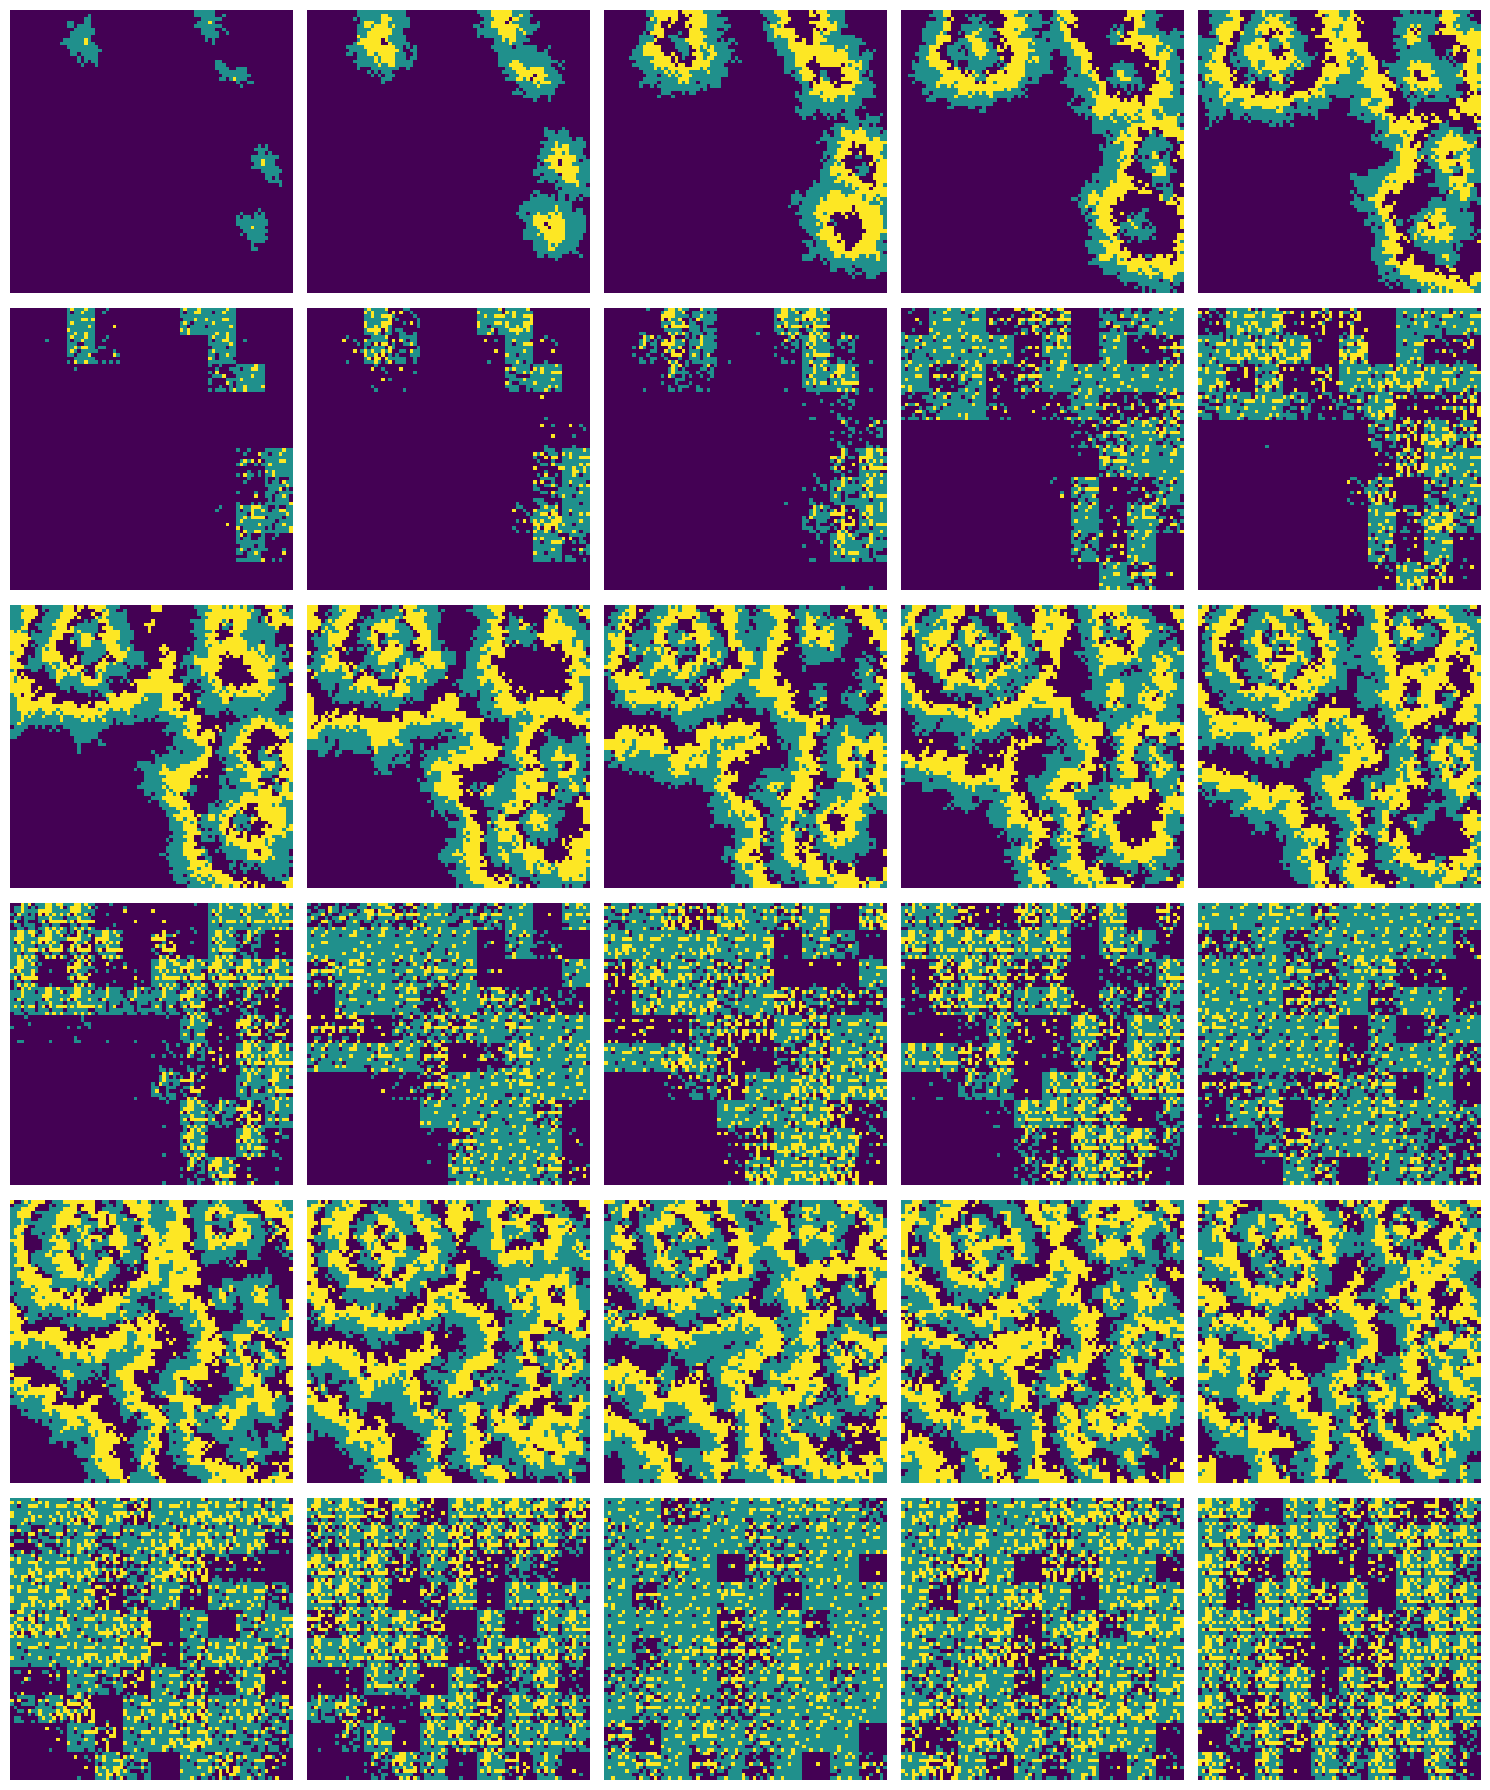

In [18]:
import matplotlib.pyplot as plt

# Enhanced comparison plot with 6x5 grid (30 slices total: 15 obs + 15 inf)
fig, ax = plt.subplots(6, 5, figsize=(15, 18))

# Convert inferred_data back to class labels for comparison
inferred_labels = np.argmax(pred_unpatched_np.squeeze(0), axis=0)  # Convert from one-hot to class labels
obs_labels = np.argmax(observational_data.squeeze(0), axis=0)  # Convert from one-hot to class labels

# Organize by rows: 
# Row 0: obs 0-4, Row 1: inf 0-4, Row 2: obs 5-9, Row 3: inf 5-9, Row 4: obs 10-14, Row 5: inf 10-14
for row in range(6):
    for col in range(5):
        # Calculate which time block we're in (0-4, 5-9, or 10-14)
        time_block = row // 2  # 0, 1, or 2
        time_idx = time_block * 5 + col  # time index within the 15 time points
        
        if time_idx < 15:  # Make sure we don't exceed our data
            if row % 2 == 0:  # Even rows (0, 2, 4) - Observed data
                im = ax[row, col].imshow(obs_labels[time_idx], cmap='viridis', vmin=0, vmax=2)
            else:  # Odd rows (1, 3, 5) - Inferred data
                im = ax[row, col].imshow(inferred_labels[time_idx], cmap='viridis', vmin=0, vmax=2)
        
        ax[row, col].axis('off')

plt.tight_layout()
plt.subplots_adjust(left=0.0, wspace=0.0)  # Make room for row labels and add horizontal spacing
plt.show()

In [19]:
abc.run(num_particles=100, max_generations=20, k=5, q_threshold=0.99)

INFO:src.viaABC.viaABC:Starting viaABC run with Q Threshold: 0.99
INFO:src.viaABC.viaABC:Initialization (generation 0) started


KeyboardInterrupt: 